In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss, make_scorer, recall_score, accuracy_score, precision_score, f1_score, cohen_kappa_score

import os, eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn import svm

Using TensorFlow backend.


Get all previous years data form 2003 onward. Using only teams that have made the tourney. 298 of approx. 360 teams have made the tourney in the past 10 years.

In [2]:
df_tourney_all = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/NCAATourneyCompactResults.csv')
df = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/RegularSeasonDetailedResults.csv')

#Limit to only tourney teams
past_trny_teams = list(set(list(df_tourney_all.WTeamID.unique()) + list(df_tourney_all.LTeamID.unique()))) 
len(past_trny_teams)

298

Get 2019 tourney teams. Correctly there are 68 teams. Format of submission is an id of 'year'_'team1id'_'team2id' and a predicted probability of team 1 winning. 

To get unique teams split by _ to get both ids, create two sets of lists combine and get unique ids.

In [3]:
df_predict = pd.read_csv('mens-machine-learning-competition-2019/SampleSubmissionStage2.csv')
grp1 = list(set(df_predict.apply(lambda row: row.ID.split('_')[1], axis=1)))
grp2 = list(set(df_predict.apply(lambda row: row.ID.split('_')[2], axis=1)))
crnt_trny_teams = list(set(grp1 + grp2))
len(crnt_trny_teams)

68

Include more descriptive data on the teams involved

In [4]:
#Team name with id, first and last D1 season
df_teams = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/Teams.csv')
#Team name matched with conf abbrev and for each season
df_team_conferences = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/TeamConferences.csv')
#conference abbrev with full name
df_conferences = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/Conferences.csv')

df_conference_names = df_team_conferences.merge(df_conferences, on=['ConfAbbrev'])

#Create tables to use as reference for combining real names with ids for full game results
win_teams = df_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
win_confs = df_conference_names.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
lose_teams = df_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
lose_confs = df_conference_names.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

# Merge winning team name and conference, losing team name and conference with season results:
df = df.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,Alabama,Southeastern Conference,Oklahoma,Big 12 Conference
1,2003,98,1400,67,1328,61,H,0,25,64,5,14,12,20,18,24,10,10,5,4,16,22,52,7,14,10,15,9,25,5,14,5,3,20,Texas,Big 12 Conference,Oklahoma,Big 12 Conference
2,2003,124,1400,76,1328,71,A,0,27,50,6,11,16,25,9,28,13,13,5,0,21,25,60,8,21,13,23,15,19,16,9,8,6,23,Texas,Big 12 Conference,Oklahoma,Big 12 Conference
3,2003,114,1281,67,1328,52,H,0,24,55,7,15,12,14,10,24,14,5,4,5,18,15,55,5,23,17,19,17,22,8,11,1,3,17,Missouri,Big 12 Conference,Oklahoma,Big 12 Conference
4,2003,70,1329,48,1328,46,H,0,19,49,1,8,9,16,10,28,4,8,4,6,17,18,55,3,12,7,15,15,23,10,6,4,3,18,Oklahoma St,Big 12 Conference,Oklahoma,Big 12 Conference


In [5]:
#Add 2pt fg data
df['WFGM2'] = df.WFGM - df.WFGM3
df['WFGA2'] = df.WFGA - df.WFGA3
df['LFGM2'] = df.LFGM - df.LFGM3
df['LFGA2'] = df.LFGA - df.LFGA3

In [6]:
print('These are the {} conferences that have participated in NCAA Division I men’s basketball since 2003, including the number of wins in the dataframe for each:'.format(len(df.WConfName.value_counts())))
df.WConfName.value_counts()

These are the 36 conferences that have participated in NCAA Division I men’s basketball since 2003, including the number of wins in the dataframe for each:


Big East Conference                   4117
Atlantic Coast Conference             3877
Southeastern Conference               3814
Atlantic 10 Conference                3649
Big Ten Conference                    3620
Big 12 Conference                     3409
Conference USA                        3301
Mid-American Conference               2938
Colonial Athletic Association         2672
Missouri Valley Conference            2650
Sun Belt Conference                   2632
Mountain West Conference              2553
Metro Atlantic Athletic Conference    2474
Southern Conference                   2391
Northeast Conference                  2320
Ohio Valley Conference                2294
Southland Conference                  2279
Horizon League                        2236
Mid-Eastern Athletic Conference       2225
West Coast Conference                 2167
Western Athletic Conference           2146
Atlantic Sun Conference               2096
America East Conference               1996
Big West Co

In [7]:
print('Season  #Games:')
df.Season.value_counts()

Season  #Games:


2018    5405
2017    5395
2016    5369
2014    5362
2015    5354
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
Name: Season, dtype: int64

Winning team description of stats

In [8]:
df[['WFGA', 'WFTA', 'WTO', 'WOR', 'WScore', 'WFGM2', 'WFGM3', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WStl', 'WBlk', 'WPF']].describe()

,WFGA,WFTA,WTO,WOR,WScore,WFGM2,WFGM3,WFGM,WFTM,WDR,WAst,WStl,WBlk,WPF
count,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000
mean,55.038334,22.776124,13.020453,10.969869,75.265916,19.005985,7.031301,26.037286,16.160042,25.586134,14.731476,7.032313,3.839288,17.487317
std,7.585434,8.133670,4.035338,4.140631,11.141337,4.702886,3.045754,4.701946,6.256617,4.898651,4.412752,3.136842,2.470696,4.138770
min,27.000000,0.000000,1.000000,0.000000,34.000000,2.000000,0.000000,10.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.000000
25%,50.000000,17.000000,10.000000,8.000000,68.000000,16.000000,5.000000,23.000000,12.000000,22.000000,12.000000,5.000000,2.000000,15.000000
50%,55.000000,22.000000,13.000000,11.000000,75.000000,19.000000,7.000000,26.000000,16.000000,25.000000,14.000000,7.000000,3.000000,17.000000
75%,60.000000,28.000000,16.000000,14.000000,82.000000,22.000000,9.000000,29.000000,20.000000,29.000000,17.000000,9.000000,5.000000,20.000000
max,103.000000,67.000000,33.000000,38.000000,144.000000,48.000000,26.000000,56.000000,48.000000,53.000000,40.000000,26.000000,21.000000,41.000000


In [9]:
df[['LFGA', 'LFTA', 'LTO', 'LOR', 'LScore', 'LFGM2', 'LFGM3', 'LFGM', 'LFTM', 'LDR', 'LAst', 'LStl', 'LBlk', 'LPF']].describe()

,LFGA,LFTA,LTO,LOR,LScore,LFGM2,LFGM3,LFGM,LFTM,LDR,LAst,LStl,LBlk,LPF
count,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.00000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000
mean,56.286796,18.094258,14.358418,11.188247,63.281201,16.539706,5.99744,22.537146,12.209468,21.534257,11.434831,6.026304,2.870845,19.827172
std,7.706462,7.154317,4.421789,4.211062,10.972665,4.309482,2.76101,4.387217,5.372825,4.529824,3.732018,2.770446,2.040549,4.527265
min,26.000000,0.000000,0.000000,0.000000,20.000000,2.000000,0.00000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000
25%,51.000000,13.000000,11.000000,8.000000,56.000000,14.000000,4.00000,20.000000,8.000000,18.000000,9.000000,4.000000,1.000000,17.000000
50%,56.000000,18.000000,14.000000,11.000000,63.000000,16.000000,6.00000,22.000000,12.000000,21.000000,11.000000,6.000000,3.000000,20.000000
75%,61.000000,23.000000,17.000000,14.000000,70.000000,19.000000,8.00000,25.000000,16.000000,24.000000,14.000000,8.000000,4.000000,23.000000
max,106.000000,61.000000,41.000000,36.000000,140.000000,40.000000,22.00000,47.000000,42.000000,49.000000,31.000000,22.000000,18.000000,45.000000


# Create some new stats

In [10]:
# Winner stats related to offensive efficiency:
df['Wposs'] = df.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
df['Wshoot_eff'] = df.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
df['Wscore_op'] = df.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
df['Woff_rtg'] = df.apply(lambda row: row.WScore/row.Wposs*100, axis=1)

# Loser stats related to offensive efficiency:
df['Lposs'] = df.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
df['Lshoot_eff'] = df.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
df['Lscore_op'] = df.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
df['Loff_rtg'] = df.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

# Defensive and net efficiency:
df['Wdef_rtg'] = df.apply(lambda row: row.Loff_rtg, axis=1)
df['Wsos'] = df.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
df['Ldef_rtg'] = df.apply(lambda row: row.Woff_rtg, axis=1)
df['Lsos'] = df.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

# Impact Estimate - 
# First calculate the teams' overall statistical contribution (the numerator):
Wie = df.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
Lie = df.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

# Then divide by the total game statistics (the denominator):
df['Wie'] = Wie / (Wie + Lie) * 100
df['Lie'] = Lie / (Lie + Wie) * 100

# Other winner stats:
df['Wts_pct'] = df.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
df['Wefg_pct'] = df.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
df['Worb_pct'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['Wdrb_pct'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['Wreb_pct'] = df.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
df['Wto_poss'] = df.apply(lambda row: row.WTO / row.Wposs, axis=1)
df['Wft_rate'] = df.apply(lambda row: row.WFTM / row.WFGA, axis=1)
df['Wast_rtio'] = df.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
df['Wblk_pct'] = df.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
df['Wstl_pct'] = df.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)
df['W3pta_pct'] = df.apply(lambda row: row.WFGA3 / row.WFGA * 100, axis=1)

# Other loser stats:
df['Lts_pct'] = df.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
df['Lefg_pct'] = df.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
df['Lorb_pct'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
df['Ldrb_pct'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
df['Lreb_pct'] = df.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
df['Lto_poss'] = df.apply(lambda row: row.LTO / row.Lposs, axis=1)
df['Lft_rate'] = df.apply(lambda row: row.LFTM / row.LFGA, axis=1)
df['Last_rtio'] = df.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
df['Lblk_pct'] = df.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
df['Lstl_pct'] = df.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)
df['L3pta_pct'] = df.apply(lambda row: row.LFGA3 / row.LFGA * 100, axis=1)

## Calculate Season Averages

In [11]:
# Initialize dataframe to hold season averages:
df_avgs = pd.DataFrame()
# Get and save number of wins and losses:
df_avgs['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
df_avgs['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

df_avgs['n_loss'].fillna(0, inplace=True)
# Calculate win percentages:
df_avgs['win_pct'] = df_avgs['n_wins'] / (df_avgs['n_wins'] + df_avgs['n_loss'])  
# df_avgs = df_avgs.reset_index()

In [12]:
def calc_avg(var):
    df_avgs['W' + var] = df['W' + var].groupby([df['Season'], df['WTeamID'], df.WTeamName, df.WConfName]).mean()
    df_avgs['L' + var] = df['L' + var].groupby([df['Season'], df['LTeamID'], df.LTeamName, df.LConfName]).mean()
    df_avgs[var] = df_avgs['W' + var] * df_avgs['win_pct'] + df_avgs['L' + var] * (1 - df_avgs['win_pct'])
    
    

In [13]:
# Calculate averages for games won:
stats = ['shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ts_pct', 'efg_pct', 'orb_pct','drb_pct', 'reb_pct',
        'to_poss', 'ft_rate', 'ie', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct']
for stat in stats:
    calc_avg(stat)

In [14]:
df_avgs.reset_index(inplace = True)
df_avgs[df_avgs['Season'] == 2014]

,Season,WTeamID,WTeamName,WConfName,n_wins,n_loss,win_pct,Wshoot_eff,Lshoot_eff,shoot_eff,Wscore_op,Lscore_op,score_op,Woff_rtg,Loff_rtg,off_rtg,Wdef_rtg,Ldef_rtg,def_rtg,Wsos,Lsos,sos,Wts_pct,Lts_pct,ts_pct,Wefg_pct,Lefg_pct,efg_pct,Worb_pct,Lorb_pct,orb_pct,Wdrb_pct,Ldrb_pct,drb_pct,Wreb_pct,Lreb_pct,reb_pct,Wto_poss,Lto_poss,to_poss,Wft_rate,Lft_rate,ft_rate,Wie,Lie,ie,Wast_rtio,Last_rtio,ast_rtio,Wblk_pct,Lblk_pct,blk_pct,Wstl_pct,Lstl_pct,stl_pct,W3pta_pct,L3pta_pct,3pta_pct
3723,2014,1101,Abilene Chr,Southland Conference,2,19.0,0.095238,1.267818,1.029811,1.052479,0.900292,0.892400,0.893152,114.118276,91.314594,93.486373,111.095779,117.242884,116.657445,3.022497,-25.928290,-23.171072,63.390886,51.490567,52.623930,0.594661,0.465271,0.477594,0.288123,0.242433,0.246784,0.673529,0.668514,0.668992,0.480826,0.455473,0.457888,0.206418,0.228608,0.226495,0.487993,0.307591,0.324772,55.662284,27.929458,30.570679,12.898381,11.434467,11.573888,5.141011,3.879733,3.999854,14.489609,7.936897,8.560965,23.434820,36.965690,35.677036
3724,2014,1102,Air Force,Mountain West Conference,10,18.0,0.357143,1.145266,1.020390,1.064989,0.931008,0.927116,0.928506,105.737066,94.153986,98.290800,95.174189,113.995464,107.273581,10.562876,-19.841478,-8.982780,57.263296,51.019512,53.249435,0.531742,0.483062,0.500448,0.300184,0.239385,0.261099,0.756765,0.668194,0.699826,0.528474,0.453790,0.480463,0.214855,0.198628,0.204423,0.350243,0.216457,0.264238,57.363544,37.085174,44.327449,15.248212,15.109399,15.158975,11.587385,8.349674,9.505999,9.025627,7.386298,7.971773,42.177427,41.424026,41.693098
3725,2014,1103,Akron,Mid-American Conference,21,12.0,0.636364,1.095640,0.954418,1.044287,0.985866,0.988131,0.986690,107.721860,94.072799,102.758565,91.637608,112.925200,99.378551,16.084252,-18.852401,3.380014,54.782023,47.720883,52.214336,0.527830,0.446478,0.498248,0.346313,0.353803,0.349037,0.695634,0.650426,0.679195,0.520974,0.502115,0.514116,0.190911,0.215649,0.199907,0.278052,0.222148,0.257723,63.059957,31.169947,51.463590,13.698896,10.233803,12.438862,11.853529,7.821124,10.387200,10.596377,8.629852,9.881277,37.347792,38.016004,37.590778
3726,2014,1104,Alabama,Southeastern Conference,12,19.0,0.387097,1.177969,0.998941,1.068242,0.966854,0.974246,0.971385,113.542736,96.788159,103.273802,92.334704,110.659198,103.565845,21.208033,-13.871039,-0.292044,58.898462,49.947037,53.412104,0.563151,0.454228,0.496392,0.324180,0.278303,0.296062,0.700841,0.635888,0.661031,0.512510,0.457096,0.478547,0.186134,0.179433,0.182027,0.312927,0.300351,0.305219,67.298433,37.315900,48.922042,14.467371,11.321883,12.539491,13.143789,10.586030,11.576130,12.925331,8.624841,10.289547,35.115879,32.889606,33.751389
3727,2014,1105,Alabama A&M,Southwest Athletic Conference,12,16.0,0.428571,1.107058,0.930731,1.006300,0.975963,0.932986,0.951405,107.651948,86.240077,95.416593,91.732585,106.163574,99.978865,15.919363,-19.923497,-4.562271,55.352922,46.536543,50.314991,0.521716,0.424503,0.466166,0.338843,0.232898,0.278303,0.682863,0.642710,0.659918,0.510853,0.437804,0.469111,0.196700,0.195934,0.196262,0.333862,0.246288,0.283820,68.357011,30.468211,46.706268,15.503872,12.707177,13.905761,12.420855,9.658582,10.842413,9.643422,8.474286,8.975344,33.828507,37.145219,35.723771
3728,2014,1106,Alabama St,Southwest Athletic Conference,16,12.0,0.571429,1.065923,0.929315,1.007377,1.016511,1.011723,1.014459,107.842027,93.443547,101.671250,94.884519,113.289459,102.772351,12.957508,-19.845912,-1.101101,53.296158,46.465751,50.368841,0.491097,0.425692,0.463066,0.364539,0.307164,0.339949,0.674010,0.619401,0.650606,0.519274,0.463282,0.495278,0.180962,0.169733,0.176150,0.310717,0.261095,0.289450,61.424525,33.553731,49.479899,13.864672,11.402385,12.809406,9.216805,9.097225,9.165556,9.803518,9.540407,9.690756,33.157006,31.574575,32.478821
3729,2014,1107,Albany NY,America East Conference,18,14.0,0.562500,1.171171,0.960358,1.078940,0.963964,0.968157,0.965798,112.461518,92.643153,103.790983,93.721178,108.146479,100.032247,18.740339,

In [15]:
df_avgs.reset_index(inplace = True)
df_avgs = df_avgs.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
df_avgs.head()

,index,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Lshoot_eff,shoot_eff,Wscore_op,Lscore_op,score_op,Woff_rtg,Loff_rtg,off_rtg,Wdef_rtg,Ldef_rtg,def_rtg,Wsos,Lsos,sos,Wts_pct,Lts_pct,ts_pct,Wefg_pct,Lefg_pct,efg_pct,Worb_pct,Lorb_pct,orb_pct,Wdrb_pct,Ldrb_pct,drb_pct,Wreb_pct,Lreb_pct,reb_pct,Wto_poss,Lto_poss,to_poss,Wft_rate,Lft_rate,ft_rate,Wie,Lie,ie,Wast_rtio,Last_rtio,ast_rtio,Wblk_pct,Lblk_pct,blk_pct,Wstl_pct,Lstl_pct,stl_pct,W3pta_pct,L3pta_pct,3pta_pct
0,0,2003,1102,Air Force,Mountain West Conference,12,16.0,0.428571,1.385301,1.055690,1.196952,0.876488,0.867953,0.871611,120.972372,90.841475,103.754717,92.784626,112.088477,103.815398,28.187745,-21.247001,-0.060681,69.265074,52.784497,59.847601,0.692162,0.503591,0.584407,0.172188,0.165271,0.168235,0.636526,0.625778,0.630384,0.404357,0.395525,0.399310,0.191909,0.214990,0.205098,0.355877,0.243105,0.291436,75.526345,28.860022,48.859875,21.645310,14.672462,17.660825,8.457639,3.591274,5.676859,12.866850,9.388406,10.879167,53.690087,50.474281,51.852484
1,1,2003,1103,Akron,Mid-American Conference,13,14.0,0.481481,1.257318,1.062243,1.156168,0.955361,0.961669,0.958632,120.043926,101.763397,110.565133,106.613550,114.354975,110.627622,13.430376,-12.591578,-0.062489,62.865925,53.112160,57.808417,0.592604,0.484527,0.536564,0.318510,0.294003,0.305803,0.620109,0.633394,0.626998,0.469309,0.463699,0.466400,0.172876,0.185367,0.179353,0.401870,0.288288,0.342976,61.544613,41.154014,50.971710,17.655516,14.022883,15.771929,4.771096,7.523921,6.198487,9.896441,10.321618,10.116903,26.339581,31.260267,28.891047
2,2,2003,1104,Alabama,Southeastern Conference,17,11.0,0.607143,1.085554,0.949278,1.032017,1.006881,0.998515,1.003595,109.038086,94.610164,103.369974,89.448746,111.355747,98.055068,19.589340,-16.745583,5.314906,54.277698,47.463923,51.600858,0.506056,0.429002,0.475785,0.367049,0.377756,0.371256,0.703299,0.661550,0.686897,0.535174,0.519653,0.529076,0.189722,0.213532,0.199076,0.278147,0.241768,0.263855,65.781984,34.904190,53.651422,14.595461,10.523001,12.995566,10.990485,9.192399,10.284094,10.541393,8.888392,9.892000,35.757004,32.957098,34.657041
3,3,2003,1105,Alabama A&M,Southwest Athletic Conference,7,19.0,0.269231,1.069884,0.971322,0.997858,0.955355,0.926856,0.934529,102.402725,89.534708,92.999174,85.740188,106.597249,100.981886,16.662536,-17.062541,-7.982712,53.494178,48.566121,49.892905,0.488400,0.446777,0.457983,0.383144,0.317489,0.335166,0.667596,0.631796,0.641434,0.525370,0.474643,0.488300,0.232357,0.244086,0.240928,0.314651,0.233885,0.255629,64.127665,33.170400,41.505048,14.608038,13.405703,13.729408,5.012616,5.010599,5.011142,14.483337,11.279258,12.141895,36.651362,32.880417,33.895671
4,4,2003,1106,Alabama St,Southwest Athletic Conference,13,15.0,0.464286,1.075419,0.952266,1.009444,0.931644,0.932745,0.932234,99.498500,88.577978,93.648220,83.171774,104.243469,94.460182,16.326726,-15.665491,-0.811962,53.770968,47.613281,50.472207,0.517668,0.450522,0.481697,0.378952,0.323938,0.349480,0.714061,0.649253,0.679342,0.546506,0.486596,0.514411,0.258413,0.244313,0.250859,0.248100,0.157829,0.199740,74.138235,34.226174,52.756774,13.657301,11.636150,12.574542,9.413412,6.716493,7.968634,13.372223,11.337570,12.282230,30.130153,34.058097,32.234409


In [16]:
# Now export averages

In [17]:
def tourn_round(DayNum):
    """
    Consolidate tournament rounds into meaningful info.
    """
    if (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif DayNum == 152:
        return 4
    elif DayNum == 154:
        return 2
    else:
        return 68
    
df_tourney_all['tourn_round'] = df_tourney_all.DayNum.apply(tourn_round)

In [18]:
df_seeds = pd.read_csv('mens-machine-learning-competition-2019/DataFiles/NCAATourneySeeds.csv')

# Get the seed number by taking the last two characters of 'Seed' values:
df_seeds['seed'] = df_seeds['Seed'].apply(lambda x : int(x[1:3]))

In [19]:
# Drop the old 'Seed' column:
df_seeds = df_seeds[['Season', 'TeamID', 'seed']]

# Merge seeds, team names, and conference names with tournament data:
df_tourney_all = df_tourney_all.merge(df_seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
.merge(df_seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

# Calculate the point differential:
df_tourney_all['point_diff'] = df_tourney_all.WScore - df_tourney_all.LScore

In [20]:
#Remove play-in games as those will mess up number of wins and don't tell us much of anything.
df_tourney_all_no_68 = df_tourney_all[df_tourney_all['tourn_round'] != 68]
#Add tourny wins to df_avgs
df_tourny_wins = df_tourney_all_no_68.groupby( [ "Season", "WTeamName"] ).size().to_frame(name = 'tourny_wins').reset_index()
df_avgs = df_avgs.merge(df_tourny_wins, how='left', left_on=['Season', 'TeamName'], right_on=['Season', 'WTeamName'])\
.drop('WTeamName', axis=1)
df_avgs


,index,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Lshoot_eff,shoot_eff,Wscore_op,Lscore_op,score_op,Woff_rtg,Loff_rtg,off_rtg,Wdef_rtg,Ldef_rtg,def_rtg,Wsos,Lsos,sos,Wts_pct,Lts_pct,ts_pct,Wefg_pct,Lefg_pct,efg_pct,Worb_pct,Lorb_pct,orb_pct,Wdrb_pct,Ldrb_pct,drb_pct,Wreb_pct,Lreb_pct,reb_pct,Wto_poss,Lto_poss,to_poss,Wft_rate,Lft_rate,ft_rate,Wie,Lie,ie,Wast_rtio,Last_rtio,ast_rtio,Wblk_pct,Lblk_pct,blk_pct,Wstl_pct,Lstl_pct,stl_pct,W3pta_pct,L3pta_pct,3pta_pct,tourny_wins
0,0,2003,1102,Air Force,Mountain West Conference,12,16.0,0.428571,1.385301,1.055690,1.196952,0.876488,0.867953,0.871611,120.972372,90.841475,103.754717,92.784626,112.088477,103.815398,28.187745,-21.247001,-0.060681,69.265074,52.784497,59.847601,0.692162,0.503591,0.584407,0.172188,0.165271,0.168235,0.636526,0.625778,0.630384,0.404357,0.395525,0.399310,0.191909,0.214990,0.205098,0.355877,0.243105,0.291436,75.526345,28.860022,48.859875,21.645310,14.672462,17.660825,8.457639,3.591274,5.676859,12.866850,9.388406,10.879167,53.690087,50.474281,51.852484,NaN
1,1,2003,1103,Akron,Mid-American Conference,13,14.0,0.481481,1.257318,1.062243,1.156168,0.955361,0.961669,0.958632,120.043926,101.763397,110.565133,106.613550,114.354975,110.627622,13.430376,-12.591578,-0.062489,62.865925,53.112160,57.808417,0.592604,0.484527,0.536564,0.318510,0.294003,0.305803,0.620109,0.633394,0.626998,0.469309,0.463699,0.466400,0.172876,0.185367,0.179353,0.401870,0.288288,0.342976,61.544613,41.154014,50.971710,17.655516,14.022883,15.771929,4.771096,7.523921,6.198487,9.896441,10.321618,10.116903,26.339581,31.260267,28.891047,NaN
2,2,2003,1104,Alabama,Southeastern Conference,17,11.0,0.607143,1.085554,0.949278,1.032017,1.006881,0.998515,1.003595,109.038086,94.610164,103.369974,89.448746,111.355747,98.055068,19.589340,-16.745583,5.314906,54.277698,47.463923,51.600858,0.506056,0.429002,0.475785,0.367049,0.377756,0.371256,0.703299,0.661550,0.686897,0.535174,0.519653,0.529076,0.189722,0.213532,0.199076,0.278147,0.241768,0.263855,65.781984,34.904190,53.651422,14.595461,10.523001,12.995566,10.990485,9.192399,10.284094,10.541393,8.888392,9.892000,35.757004,32.957098,34.657041,NaN
3,3,2003,1105,Alabama A&M,Southwest Athletic Conference,7,19.0,0.269231,1.069884,0.971322,0.997858,0.955355,0.926856,0.934529,102.402725,89.534708,92.999174,85.740188,106.597249,100.981886,16.662536,-17.062541,-7.982712,53.494178,48.566121,49.892905,0.488400,0.446777,0.457983,0.383144,0.317489,0.335166,0.667596,0.631796,0.641434,0.525370,0.474643,0.488300,0.232357,0.244086,0.240928,0.314651,0.233885,0.255629,64.127665,33.170400,41.505048,14.608038,13.405703,13.729408,5.012616,5.010599,5.011142,14.483337,11.279258,12.141895,36.651362,32.880417,33.895671,NaN
4,4,2003,1106,Alabama St,Southwest Athletic Conference,13,15.0,0.464286,1.075419,0.952266,1.009444,0.931644,0.932745,0.932234,99.498500,88.577978,93.648220,83.171774,104.243469,94.460182,16.326726,-15.665491,-0.811962,53.770968,47.613281,50.472207,0.517668,0.450522,0.481697,0.378952,0.323938,0.349480,0.714061,0.649253,0.679342,0.546506,0.486596,0.514411,0.258413,0.244313,0.250859,0.248100,0.157829,0.199740,74.138235,34.226174,52.756774,13.657301,11.636150,12.574542,9.413412,6.716493,7.968634,13.372223,11.337570,12.282230,30.130153,34.058097,32.234409,NaN
5,5,2003,1107,Albany NY,America East Conference,7,21.0,0.250000,1.103071,1.008324,1.032010,0.937483,0.936069,0.936422,103.415314,94.072431,96.408152,94.976381,114.064159,109.292214,8.438933,-19.991728,-12.884063,55.153526,50.416177,51.600514,0.517870,0.479379,0.489002,0.265434,0.223826,0.234228,0.683675,0.565104,0.594747,0.474555,0.394465,0.414488,0.195153,0.181491,0.184906,0.222100,0.159086,0.174839,53.804503,35.132717,39.800664,12.676221,13.634994,13.395301,7.635792,4.156600,5.026398,9.027183,10.287375,9.972327,37.922950,38.990102,38.723314,NaN
6,6,2003,1108,Alcorn St,Southwest Athletic Conference,14,19.0,0.424242,1.105588,0.941536,1.011134,0.934954,0.928406,0.931184,103.108903,86.547662,93.573643,88.

In [21]:
df_avgs = df_avgs.fillna(0)

# Upset Exploration

In [22]:
df_tourney_all['upset'] = df_tourney_all.apply(lambda row: row.Wseed > row.Lseed, axis=1)
df_tourney_all = df_tourney_all.merge(df_avgs[['TeamName', 'Season', 'tourny_wins']], left_on=['WTeamName', 'Season'],
                      right_on=['TeamName', 'Season']).drop('TeamName', axis=1)

In [23]:
upsets = df_tourney_all[df_tourney_all['upset'] == True]

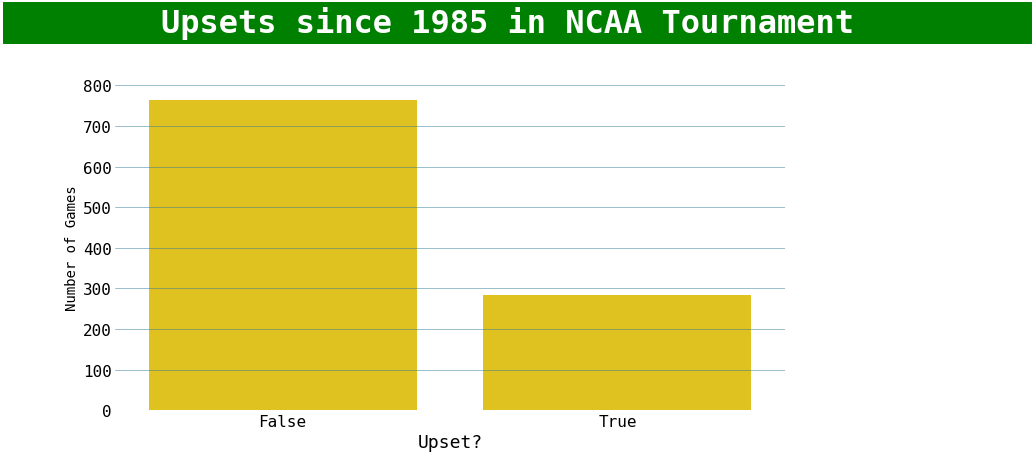

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=df_tourney_all['upset'], color='#FFD700')
plt.box(False)

fig.text(x=0, y=1, s='        Upsets since 1985 in NCAA Tournament         ', fontsize=32, weight='bold', color='white', backgroundcolor='green')

ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Games', fontsize=14), plt.xlabel('Upset?', fontsize=18);

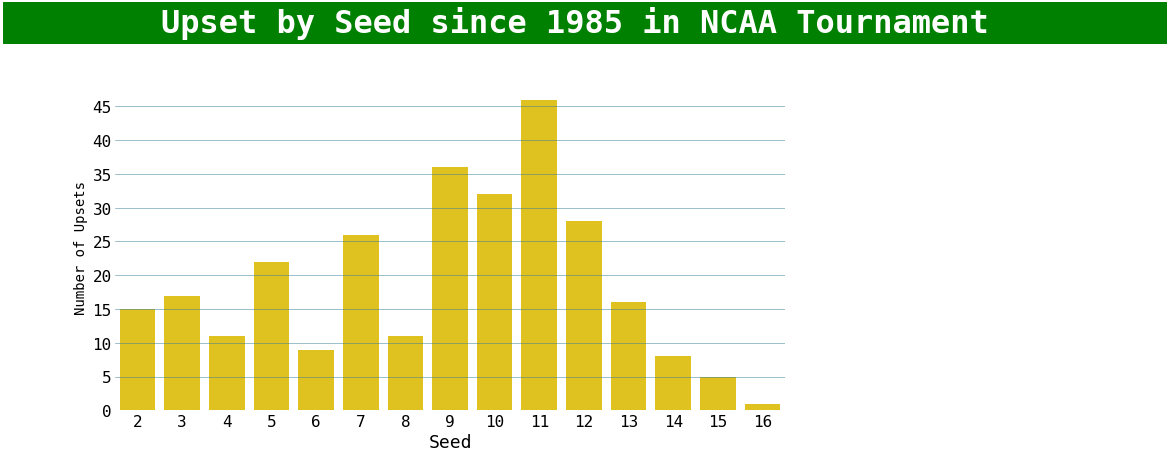

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=df_tourney_all[df_tourney_all['upset'] == True].Wseed, color='#FFD700')
plt.box(False)

fig.text(x=0, y=1, s='        Upset by Seed since 1985 in NCAA Tournament         ', fontsize=32, weight='bold', color='white', backgroundcolor='green')

ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Upsets', fontsize=14), plt.xlabel('Seed', fontsize=18);

Naturally seeds above 9 have the most "upsets". These teams all get a shot at an upset in the first game. 9's are just playing 8's and it counts as an upset, whereas 8s must be a 9 then a 1 to get a singular upset.

I'll look at the average difference between a the seeds in an upset.

In [26]:
upsets['seed_dif'] = upsets.apply(lambda row: row.Wseed - row.Lseed, axis=1)
upsets['seed_dif'].mean()

4.498233215547703

,Wseed,seed_dif
0,2,1.000000
1,3,1.352941
2,4,2.454545
3,5,1.590909
4,6,3.111111
5,7,4.307692
6,8,5.818182
7,9,2.138889
8,10,4.406250
9,11,5.673913


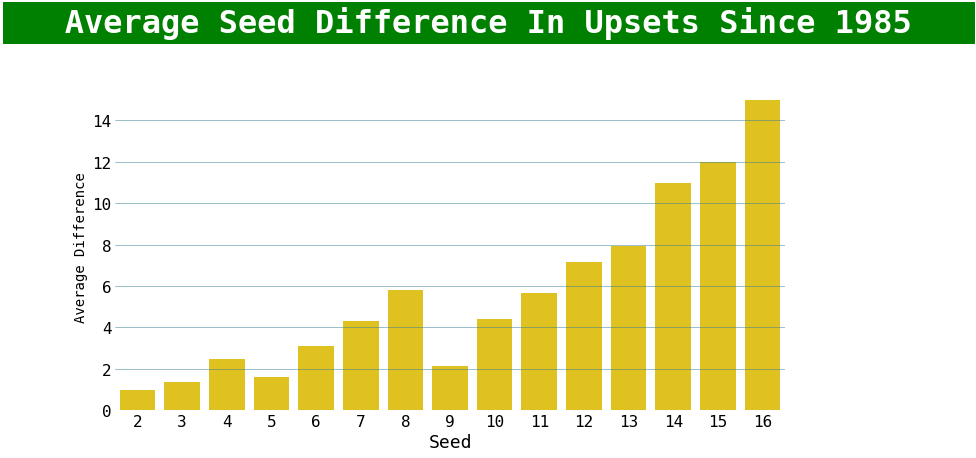

In [27]:
upset_seed_dif = upsets.groupby('Wseed').seed_dif.mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data= upset_seed_dif, x='Wseed',y='seed_dif', color='#FFD700')
plt.box(False)

fig.text(x=0, y=1, s='   Average Seed Difference In Upsets Since 1985   ', fontsize=32, weight='bold', color='white', backgroundcolor='green')

ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Average Difference', fontsize=14), plt.xlabel('Seed', fontsize=18);

display(upset_seed_dif)

The difference mentioned above about 9s and 8s having different opportunities of creating an upset is on full display in the average seed difference of upsets. 9s average is 1.74 mmeaning that when they do beat the 8 seed they rarely beat the 1 seed in the next round. It looks like 8s are much better at providing big upsets, but that is only because their average does not include all the differences of 1 from beating the seed below them.

All other seeds above 9's upset difference stick around the difference between their first opponent (12 plays 5 so the difference is slightly above 7). This doesn't tell us much about which seeds produce good upsets. 

In [28]:
df_9_vs_1 = df_tourney_all[((df_tourney_all['Wseed'] == 9) & (df_tourney_all['Lseed'] == 1)) | 
              ((df_tourney_all['Wseed'] == 1) & (df_tourney_all['Lseed'] == 9))]

display(df_9_vs_1['Wseed'].groupby([df_9_vs_1.Wseed]).count())
display(df_9_vs_1['Wseed'].groupby([df_9_vs_1.Wseed]).count() / df_9_vs_1['Wseed'].count())

df_8_vs_1 = df_tourney_all[((df_tourney_all['Wseed'] == 8) & (df_tourney_all['Lseed'] == 1)) | 
              ((df_tourney_all['Wseed'] == 1) & (df_tourney_all['Lseed'] == 8))]

display(df_8_vs_1['Wseed'].groupby([df_8_vs_1.Wseed]).count())
display(df_8_vs_1['Wseed'].groupby([df_8_vs_1.Wseed]).count()  / df_8_vs_1['Wseed'].count())


Wseed
1    25
9     4
Name: Wseed, dtype: int64

Wseed
1    0.862069
9    0.137931
Name: Wseed, dtype: float64

Wseed
1    30
8     5
Name: Wseed, dtype: int64

Wseed
1    0.857143
8    0.142857
Name: Wseed, dtype: float64

The 8 seeds actually do fare better than the 9 seeds against 1 seeds. With 68 games for the 9 seeds and 70 for the 8 seeds the 8 seeds have a significantly higher win rate. 20% for 8 seeds vs ~9% for 9 seeds.

So what does this all mean? Not much, except that maybe the selection committee can actually seed properly? That can't be it...

We can look at first round matchups to see how often they are right when no madness has occurred making unforeseeable matchups.

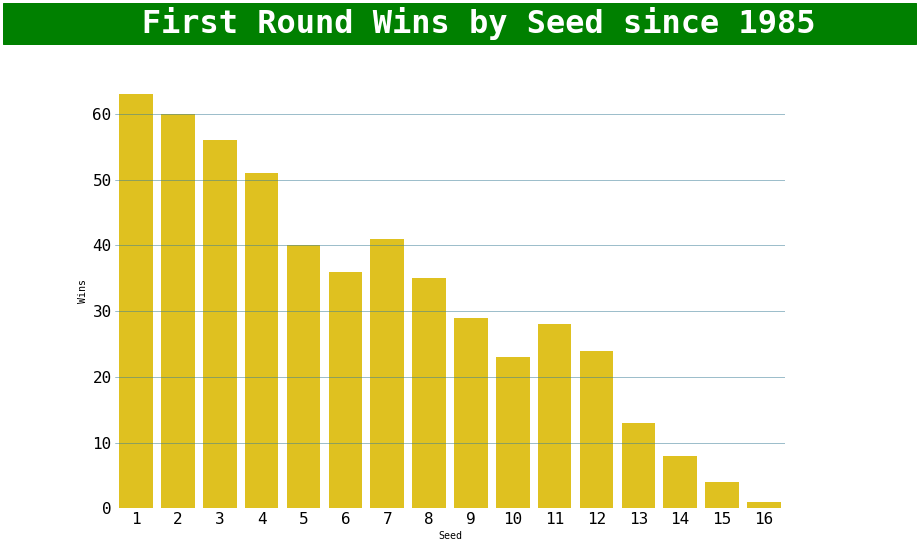

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=df_tourney_all[df_tourney_all.tourn_round == 64].Wseed, color='#FFD700')
plt.box(False)

fig.text(x=0, y=0.95, s='       First Round Wins by Seed since 1985     ', fontsize=32, weight='bold', color='white', backgroundcolor='green')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('Seed'), plt.ylabel('Wins');

In [30]:
upsets[df_tourney_all['Wseed'] > df_tourney_all['Lseed']].WTeamName.count()  

283

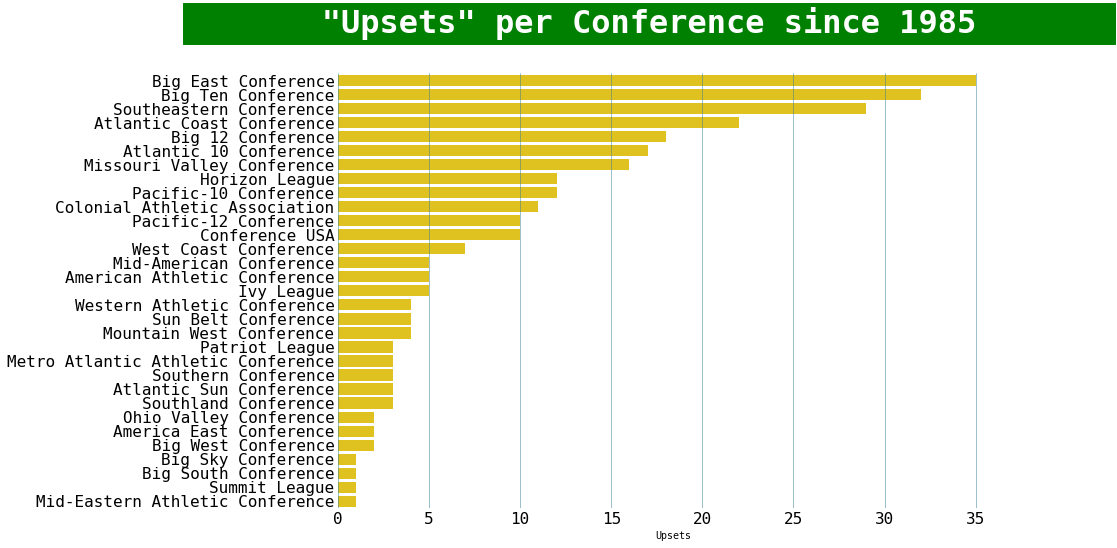

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=upsets.WConfName, order=upsets.WConfName.value_counts().index, color='#FFD700')
plt.box(False)

fig.text(x=-0.05, y=0.95, s='       "Upsets" per Conference since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='green')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('Upsets'), plt.ylabel('');


Of course some of these conferences don't exist anymore like the Big Eight Conference. With schools like University of Kansas and Oklahoma this eventually became the Big 12. Similarly the Pac-10 no longer exists as it changed it's name to the Pac-12 to represent the number of representatives within the conference (unlike some other conferences \**cough** Big 10 \**cough**).

The teams near the top are all mostly considered power conferences. The term power conference was formed for NCAA football as these were the five conferences in Football Subdivision (FBS). In basketball it is a little more broad because subdivisions do not exist. Generally speaking these "high-major" schools have the most money and best resources so when they win a game as a lower seed it's not much of an upset or "Cinderella Story". Usually when a team from one of these conferences wins an upset they are .500 in their conference and squeak in over a mid-major with well over 20 wins. We want to focus on mid major conferences like the Atlantic 10 (More than 10 schools \**sigh**), Missouri Valley, and West Coast Conference.

I will remove all the high-major conferences of Big East, Southeastern, Big 10, ACC, Pac-x, big 12/8

In [32]:
power_conf = ['Big East Conference', 'Southeastern Conference', 'Big Ten Conference', 'Atlantic Coast Conference',
              'Pacific-10 Conference', 'Pacific-12 Conference', 'Big Eight Conference', 'Big 12 Conference',
             'American Athletic Conference']
upsets = upsets[~upsets.WConfName.isin(power_conf)]

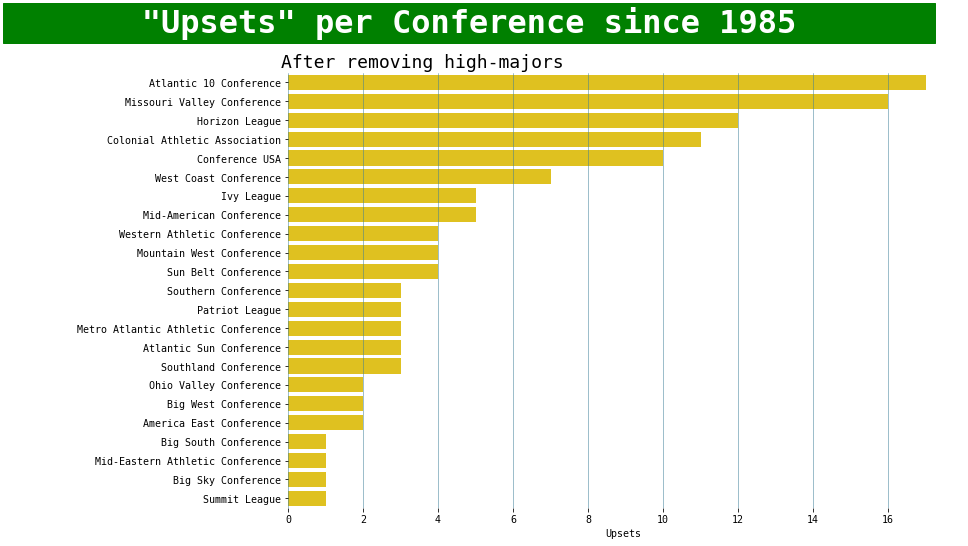

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=upsets.WConfName, order=upsets.WConfName.value_counts().index, color='#FFD700')
plt.box(False)

fig.text(x=-.2, y=0.95, s='       "Upsets" per Conference since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='green')

plt.title(x=.2,label="After removing high-majors", fontsize='18')
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('Upsets'), plt.ylabel('');

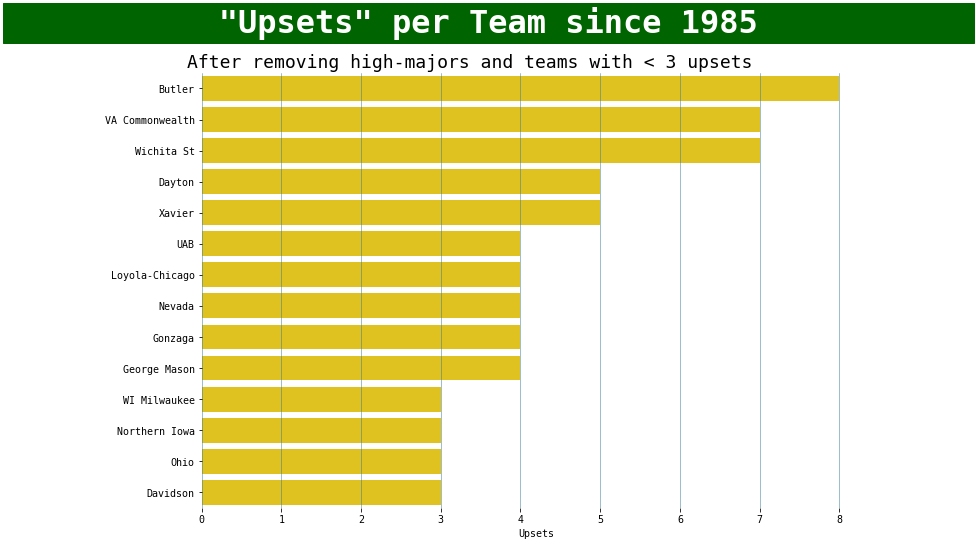

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=upsets.WTeamName, order=upsets.WTeamName.value_counts().index[upsets.WTeamName.value_counts() > 2], color='#FFD700')
plt.box(False)

fig.text(x=-.1, y=0.95, s='           "Upsets" per Team since 1985           ', fontsize=32, weight='bold', color='white', backgroundcolor='darkgreen')

plt.title(x=.4,label="After removing high-majors and teams with < 3 upsets", fontsize='18')
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('Upsets'), plt.ylabel('');

Many of these high totals are based off of one long run like 11 seeded Loyola-Chicago's final 4 run in 2018 powered by Sister Jean, George Mason's final 4 run in 2006 also an 11 seed, or Steph Curry carrying 10 seed Davidson to the Elite 8 in 2008. All wins post 1985 for these teams came from a singular run.

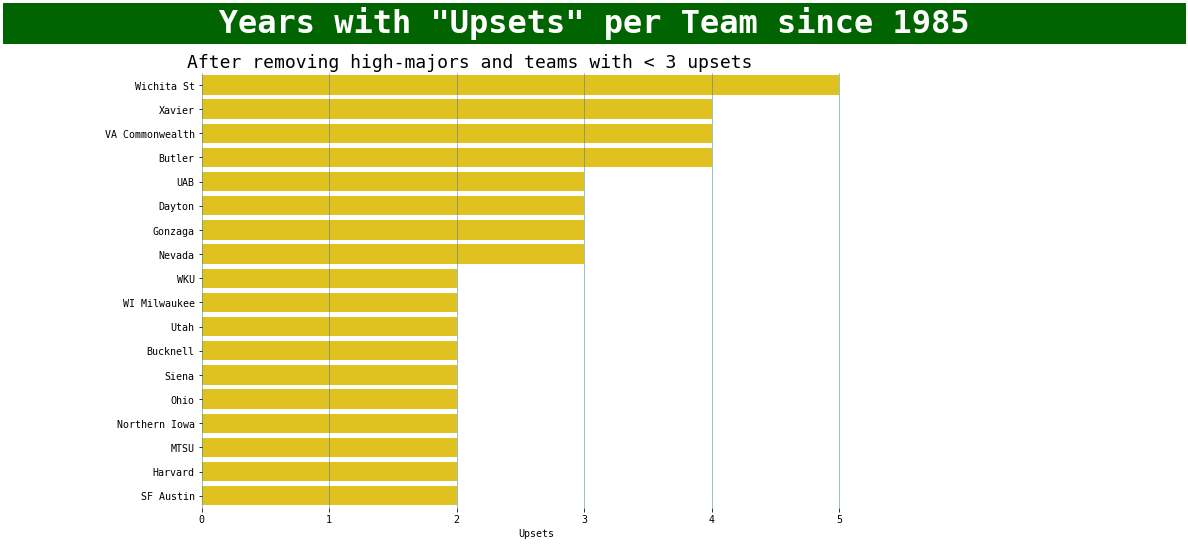

In [35]:
df_season_upsets = upsets.groupby(['WTeamName']).agg({"Season": pd.Series.nunique})
df_season_upsets = df_season_upsets[df_season_upsets['Season'] > 1].reset_index()

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data = df_season_upsets.sort_values(by=['Season'], ascending=False),y='WTeamName', x='Season', color='#FFD700')
plt.box(False)

fig.text(x=-.1, y=0.95, s='           Years with "Upsets" per Team since 1985           ', fontsize=32, weight='bold', color='white', backgroundcolor='darkgreen')

plt.title(x=.4,label="After removing high-majors and teams with < 3 upsets", fontsize='18')
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('Upsets'), plt.ylabel('');

# How Far?

How far does an average team that pulls off an upset go?

In [36]:
df_tourny_wins = df_avgs.merge(df_seeds, on=['Season', 'TeamID'])
df_tourny_first_upset = df_avgs.merge(upsets, how='left', left_on=['Season', 'TeamName'], right_on=['Season', 'WTeamName'])
df_tourny_first_upset

,index,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Lshoot_eff,shoot_eff,Wscore_op,Lscore_op,score_op,Woff_rtg,Loff_rtg,off_rtg,Wdef_rtg,Ldef_rtg,def_rtg,Wsos,Lsos,sos,Wts_pct,Lts_pct,ts_pct,Wefg_pct,Lefg_pct,efg_pct,Worb_pct,Lorb_pct,orb_pct,Wdrb_pct,Ldrb_pct,drb_pct,Wreb_pct,Lreb_pct,reb_pct,Wto_poss,Lto_poss,to_poss,Wft_rate,Lft_rate,ft_rate,Wie,Lie,ie,Wast_rtio,Last_rtio,ast_rtio,Wblk_pct,Lblk_pct,blk_pct,Wstl_pct,Lstl_pct,stl_pct,W3pta_pct,L3pta_pct,3pta_pct,tourny_wins_x,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff,upset,tourny_wins_y,seed_dif
0,0,2003,1102,Air Force,Mountain West Conference,12,16.0,0.428571,1.385301,1.055690,1.196952,0.876488,0.867953,0.871611,120.972372,90.841475,103.754717,92.784626,112.088477,103.815398,28.187745,-21.247001,-0.060681,69.265074,52.784497,59.847601,0.692162,0.503591,0.584407,0.172188,0.165271,0.168235,0.636526,0.625778,0.630384,0.404357,0.395525,0.399310,0.191909,0.214990,0.205098,0.355877,0.243105,0.291436,75.526345,28.860022,48.859875,21.645310,14.672462,17.660825,8.457639,3.591274,5.676859,12.866850,9.388406,10.879167,53.690087,50.474281,51.852484,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2003,1103,Akron,Mid-American Conference,13,14.0,0.481481,1.257318,1.062243,1.156168,0.955361,0.961669,0.958632,120.043926,101.763397,110.565133,106.613550,114.354975,110.627622,13.430376,-12.591578,-0.062489,62.865925,53.112160,57.808417,0.592604,0.484527,0.536564,0.318510,0.294003,0.305803,0.620109,0.633394,0.626998,0.469309,0.463699,0.466400,0.172876,0.185367,0.179353,0.401870,0.288288,0.342976,61.544613,41.154014,50.971710,17.655516,14.022883,15.771929,4.771096,7.523921,6.198487,9.896441,10.321618,10.116903,26.339581,31.260267,28.891047,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2003,1104,Alabama,Southeastern Conference,17,11.0,0.607143,1.085554,0.949278,1.032017,1.006881,0.998515,1.003595,109.038086,94.610164,103.369974,89.448746,111.355747,98.055068,19.589340,-16.745583,5.314906,54.277698,47.463923,51.600858,0.506056,0.429002,0.475785,0.367049,0.377756,0.371256,0.703299,0.661550,0.686897,0.535174,0.519653,0.529076,0.189722,0.213532,0.199076,0.278147,0.241768,0.263855,65.781984,34.904190,53.651422,14.595461,10.523001,12.995566,10.990485,9.192399,10.284094,10.541393,8.888392,9.892000,35.757004,32.957098,34.657041,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2003,1105,Alabama A&M,Southwest Athletic Conference,7,19.0,0.269231,1.069884,0.971322,0.997858,0.955355,0.926856,0.934529,102.402725,89.534708,92.999174,85.740188,106.597249,100.981886,16.662536,-17.062541,-7.982712,53.494178,48.566121,49.892905,0.488400,0.446777,0.457983,0.383144,0.317489,0.335166,0.667596,0.631796,0.641434,0.525370,0.474643,0.488300,0.232357,0.244086,0.240928,0.314651,0.233885,0.255629,64.127665,33.170400,41.505048,14.608038,13.405703,13.729408,5.012616,5.010599,5.011142,14.483337,11.279258,12.141895,36.651362,32.880417,33.895671,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2003,1106,Alabama St,Southwest Athletic Conference,13,15.0,0.464286,1.075419,0.952266,1.009444,0.931644,0.932745,0.932234,99.498500,88.577978,93.648220,83.171774,104.243469,94.460182,16.326726,-15.665491,-0.811962,53.770968,47.613281,50.472207,0.517668,0.450522,0.481697,0.378952,0.323938,0.349480,0.714061,0.649253,0.679342,0.546506,0.486596,0.514411,0.258413,0.244313,0.250859,0.248100,0.157829,0.199740,74.138235,34.226174,52.756774,13.657301,11.636150,12.574542,9.413412,6.716493,7.968634,13.372223,11.337570,12.282230,30.130153,34.058097,32.234409,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2003,1107,Albany NY,America East Conference,7,21.0,0.250000,1.103071,1.008324,1.032010,0.937483,0.936069,0.936422,103.415314,94.072431,96.408152,94.976381,114.064159,109.292214,8.438933,-19.9917

In [37]:
#Average of number of wins for each seed
#Need new df which has team name, year, seed, wins

df_tourny_wins = df_avgs.merge(df_seeds, on=['Season', 'TeamID'])
grouped_df = df_tourny_wins[['Season', 'TeamName', 'seed', 'tourny_wins']].groupby(['seed'])
df_tourny_wins_describe = grouped_df['tourny_wins'].agg([np.sum, np.size, np.mean, np.std]).reset_index()
df_tourny_wins_describe['mean']

0     3.296875
1     2.296875
2     2.015625
3     1.531250
4     1.109375
5     0.828125
6     1.078125
7     0.734375
8     0.593750
9     0.546875
10    0.640000
11    0.477612
12    0.246154
13    0.123077
14    0.078125
15    0.011364
Name: mean, dtype: float64

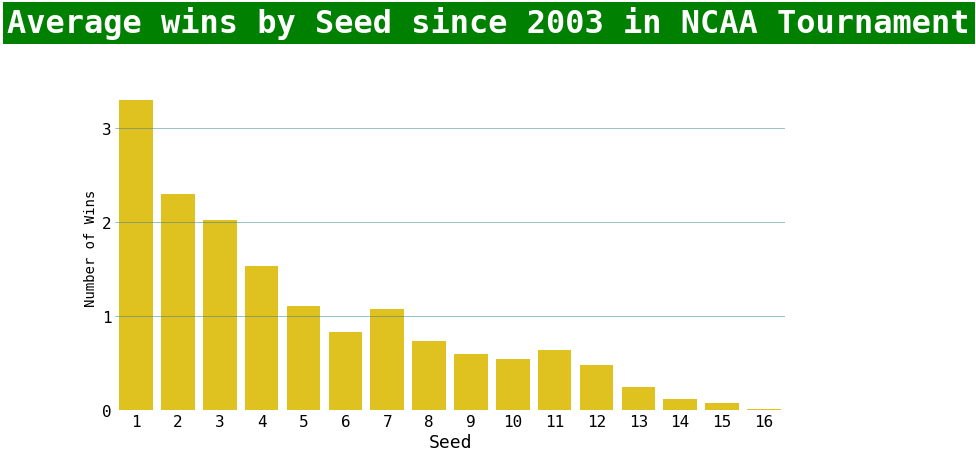

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=df_tourny_wins_describe.seed, y=df_tourny_wins_describe['mean'], color='#FFD700')
plt.box(False)
    
fig.text(x=0, y=1, s='Average wins by Seed since 2003 in NCAA Tournament', fontsize=32, weight='bold', color='white', backgroundcolor='green')

ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Wins', fontsize=14), plt.xlabel('Seed', fontsize=18);

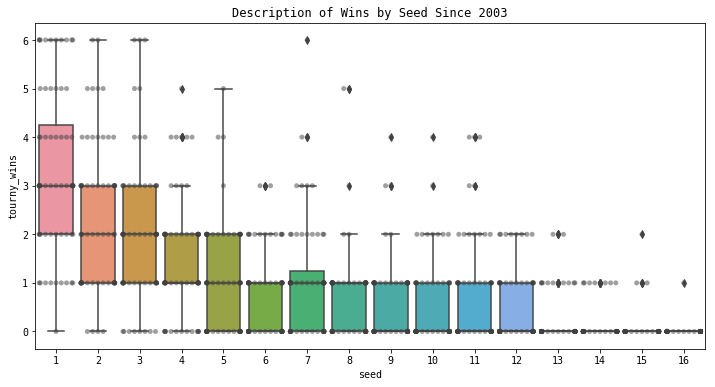

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x="seed", y="tourny_wins", data=df_tourny_wins);
ax = sns.swarmplot(x="seed", y="tourny_wins", data=df_tourny_wins, alpha=.5, s=5, color='.25')
plt.title('Description of Wins by Seed Since 2003');

From the boxplot above you can see that the median 1 seed wins 3 games (making the elite 8). An interesting aspect mentioned earlier is that 8's and 9's have trouble winning more than 1 game because they have to play a 1 seed if they win. 7's and 10's both have more teams making it past the rd of 32 than 8s and 9s. In a way this shows the difference in quality between 1 and 2 seeds. 10 seeds have a better record in the second round than 8's and 9's.

This probably indicates that if you want to be an underdog story some seeds are better than others. 12's have a good first round win rate but have not made it past the sweet 16, but 11 has had 3 and 10 2.

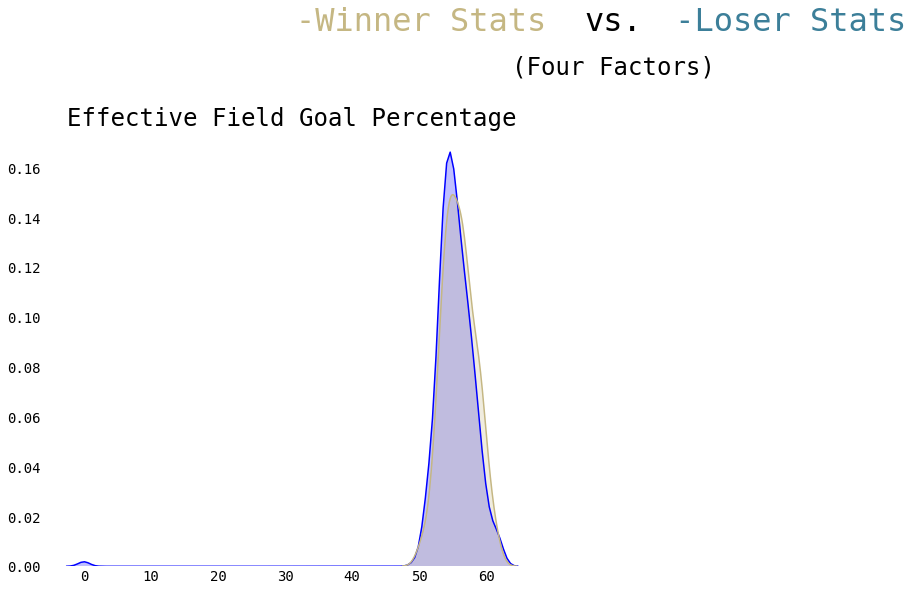

In [40]:
fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(2, 2, wspace=0.25, hspace=0.5)

fig.text(x=0.30, y=0.95, s='-Winner Stats', fontsize=32, color='#c5b783')
fig.text(x=0.50, y=0.95, s='vs.', fontsize=32)
fig.text(x=0.55, y=0.95, s=' -Loser Stats', fontsize=32, color='#3c7f99')
fig.text(x=0.45, y=0.92, s='(Four Factors)', fontsize=24)
    

plt.subplot(grid[0, :1])
sns.kdeplot(df_tourny_wins[df_tourny_wins['tourny_wins'] == 1].ts_pct, shade=True, legend=False, color='blue')
sns.kdeplot(df_tourny_wins[df_tourny_wins['tourny_wins'] == 2].ts_pct, shade=True, legend=False, color='#c5b783')
plt.title('Effective Field Goal Percentage', fontsize=24)
plt.box(False)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=14)

In [41]:
from scipy.stats import pearsonr

features = ['seed', 'win_pct','shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'tourny_wins']
for feature in features:
    x = df_tourny_wins[feature]
    y = df_tourny_wins['tourny_wins']
    corr, _ = pearsonr(x, y)
    print('%s: %.3f' % (feature, corr))
x = df_tourny_wins['sos']
y = df_tourny_wins['ie']
corr, _ = pearsonr(x, y)
print('Pearsons correlation: %.3f' % corr)

seed: -0.599
win_pct: 0.404
shoot_eff: 0.083
score_op: 0.113
off_rtg: 0.215
def_rtg: -0.229
sos: 0.467
efg_pct: 0.105
to_poss: -0.182
orb_pct: 0.177
ft_rate: -0.089
reb_pct: 0.113
ts_pct: 0.083
ast_rtio: 0.142
blk_pct: 0.212
stl_pct: 0.088
3pta_pct: -0.062
tourny_wins: 1.000
Pearsons correlation: 0.854


In [53]:
df_tourny_wins_features = df_tourny_wins[['seed', 'win_pct','shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct', '3pta_pct', 'tourny_wins']]

df_tourny_wins_features = pd.get_dummies(df_tourny_wins_features, columns = ['seed'])

X = df_tourny_wins_features.drop('tourny_wins', axis=1)
y = df_tourny_wins_features.tourny_wins

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

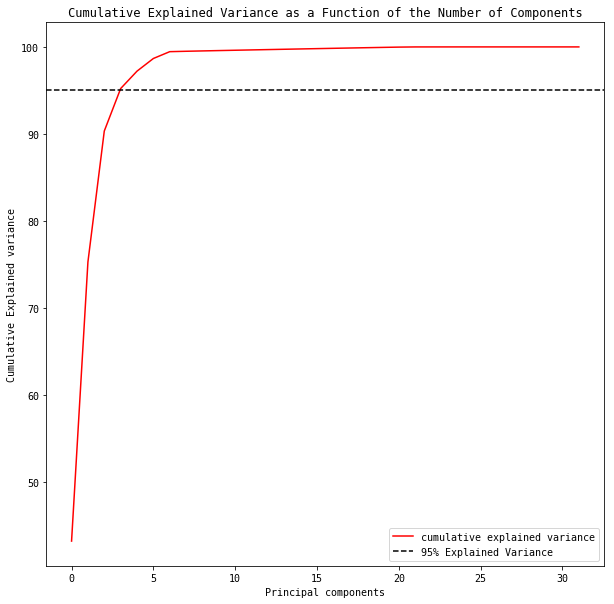

In [54]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

Performing model optimizations...

Estimator: Support Vector Machine
Best params: {'clf__C': 1, 'clf__kernel': 'linear'}
Best training accuracy: 0.264
Test set accuracy score for best params: 0.568 


,win_pct,shoot_eff,score_op,off_rtg,def_rtg,sos,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,pred,real
525,0.617647,1.043596,1.001798,104.077361,100.046715,4.030647,0.476153,0.190499,0.343092,0.285582,0.501071,52.179816,11.439315,10.673968,8.504556,39.842046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0
510,0.741935,1.144037,0.961481,109.492575,99.536760,9.955814,0.527616,0.191537,0.327854,0.356121,0.489443,57.201864,13.776831,12.416193,8.286690,30.000367,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0
308,0.727273,1.118922,1.023264,114.228359,99.992661,14.235698,0.520451,0.170696,0.365134,0.294966,0.514504,55.946081,13.855735,14.254700,10.612425,36.619393,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0
873,0.696970,1.147843,1.033058,118.271222,104.954218,13.317004,0.539428,0.145191,0.337161,0.294845,0.498261,57.392139,14.238838,9.399479,9.192911,40.408547,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0
860,0.757576,1.159035,0.984336,113.481446,96.457909,17.023537,0.542450,0.178048,0.345147,0.333373,0.550686,57.951728,14.765558,11.448747,6.884486,29.258690,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0
345,0.781250,1.153542,0.957372,110.159342,91.201147,18.958195,0.542639,0.203764,0.339919,0.293235,0.522437,57.677092,15.080985,13.419081,10.825908,31.569516,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.0,0.0
559,0.575758,1.078256,0.990726,106.031408,104.088486,1.942923,0.505350,0.176982,0.324527,0.234624,0.511662,53.912806,14.879801,7.431431,7.291587,36.655308,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0
369,0.806452,1.157074,0.972475,112.262191,96.547940,15.714251,0.540124,0.207057,0.373443,0.347804,0.538705,57.853677,16.251722,8.113667,8.978447,33.582441,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0
67,0.533333,1.038098,0.918959,95.315566,93.389206,1.926360,0.482844,0.262506,0.371628,0.311386,0.521627,51.904903,11.691977,8.508059,10.615086,34.110010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0
155,0.785714,1.189631,0.970440,115.448218,94.530270,20.917947,0.555712,0.204409,0.386554,0.288547,0.560454,59.481540,18.247364,7.506680,11.463004,34.037563,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,4.0



Classifier with best test set accuracy: Support Vector Machine


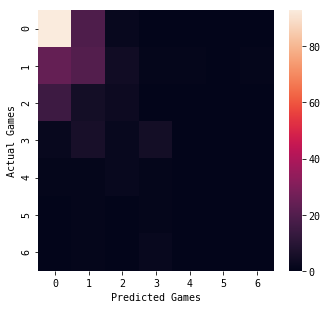

In [55]:
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42, multi_class='multinomial'))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=4)),
            ('clf', LogisticRegression(random_state=42, multi_class='multinomial'))])

pipe_rf = Pipeline([('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', svm.SVC(random_state=42))])

param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
jobs = -1
scorers = {
    'cohen_kappa_score': make_scorer(cohen_kappa_score)
}

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_lr = [{'clf__penalty': ['l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['lbfgs']}] 

grid_params_svm = [{'clf__kernel': ['linear', 'poly', 'rbf'], 
        'clf__C': param_range}]

# gs_lr = GridSearchCV(estimator=pipe_lr,
#             param_grid=grid_params_lr,
#             scoring=scorers,
#             refit='cohen_kappa_score',
#             cv=10) 

# gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
#             param_grid=grid_params_lr,
#             scoring=scorers,
#             refit='cohen_kappa_score',
#             cv=10)

# gs_rf = GridSearchCV(estimator=pipe_rf,
#             param_grid=grid_params_rf,
#             scoring=scorers,
#             refit='cohen_kappa_score',
#             cv=10, 
#             n_jobs=jobs)

# gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
#             param_grid=grid_params_rf,
#             scoring=scorers,
#             refit='cohen_kappa_score',
#             cv=10, 
#             n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring=scorers,
            refit='cohen_kappa_score',
            cv=10,
            n_jobs=jobs)

# gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
#             param_grid=grid_params_svm,
#             scoring=scorers,
#             refit='cohen_kappa_score',
#             cv=10,
#             n_jobs=jobs)

# List of pipelines for ease of iteration
# grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]
grids = [gs_svm]

# Dictionary of pipelines and classifier types for ease of reference
# grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
#         2: 'Random Forest', 3: 'Random Forest w/PCA', 
#         4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}
grid_dict = {0: 'Support Vector Machine'}

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
#     display(gs.best_estimator_.named_steps["clf"].feature_importances_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    view = X_test.copy()
    view['pred'] = y_pred
    view['real'] = y_test
    display(view)
    
    # Confusion matrix labels:
#     labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, y_pred)
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx

print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

In [56]:
#Best svm c=5 kernel=linear 0.568

In [57]:
y_pred = np.zeros((213))
accuracy_score(y_test, y_pred)

0.5352112676056338

In [58]:
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', Ridge())])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA()),
            ('clf', Ridge())])


alpha_to_test = 2.0**np.arange(-6, +10)
n_features_to_test = np.arange(1, 21)

params_pca = {'pca__n_components': n_features_to_test,\
              'clf__alpha': alpha_to_test}

params = {'clf__alpha': alpha_to_test}

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=params,
            cv=10) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
            param_grid=params_pca,
            cv=10)

grids = [gs_lr, gs_lr_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Linear Regression', 1: 'Linear Regression w/PCA'}

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
#     display(gs.best_estimator_.named_steps["clf"].feature_importances_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % gs.score(X_test, y_test))
    view = X_test.copy()
    view['pred'] = y_pred
    view['real'] = y_test
    display(view[view['seed_7'] == 1])
    
    # Track best (highest test accuracy) model
    if gs.score(X_test, y_test) > best_acc:
        best_acc = gs.score(X_test, y_test)
        best_gs = gs
        best_clf = idx

print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Linear Regression
Best params: {'clf__alpha': 64.0}
Best training accuracy: 0.402
Test set accuracy score for best params: 0.356 


,win_pct,shoot_eff,score_op,off_rtg,def_rtg,sos,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,pred,real
345,0.781250,1.153542,0.957372,110.159342,91.201147,18.958195,0.542639,0.203764,0.339919,0.293235,0.522437,57.677092,15.080985,13.419081,10.825908,31.569516,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.290478,0.0
135,0.750000,1.071995,1.021271,109.079411,99.368801,9.710609,0.501385,0.182746,0.373097,0.289812,0.516758,53.599736,14.013783,8.395758,12.043606,35.540663,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.015968,0.0
761,0.818182,1.123437,0.998765,111.812414,99.306532,12.505882,0.517760,0.159670,0.322560,0.349411,0.521805,56.171829,16.521327,13.877311,7.222945,31.628622,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.924787,0.0
204,0.666667,1.097791,0.961131,105.214394,99.239513,5.974881,0.503299,0.188789,0.313096,0.341085,0.508283,54.889529,14.618075,7.644047,7.897769,28.035550,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.724750,0.0
767,0.718750,1.166525,0.988094,114.719195,103.333916,11.385280,0.540652,0.163449,0.323562,0.335469,0.502366,58.326268,14.887487,9.060453,11.091301,34.199772,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.018074,1.0
897,0.600000,1.064084,0.986977,104.795955,103.022842,1.773113,0.499951,0.167851,0.292959,0.255994,0.488255,53.204206,14.284106,9.310084,10.732760,32.092575,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.834565,0.0
572,0.741935,1.081188,0.988139,106.572605,96.117094,10.455511,0.495946,0.203241,0.376177,0.339933,0.539020,54.059400,14.733537,4.601265,10.016383,30.789106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.841172,0.0
734,0.764706,1.115429,0.975075,108.654090,95.113563,13.540528,0.512951,0.177779,0.311689,0.296877,0.489913,55.771465,13.995346,16.085587,10.465666,33.924328,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.162525,6.0



Estimator: Linear Regression w/PCA
Best params: {'clf__alpha': 2.0, 'pca__n_components': 20}
Best training accuracy: 0.323
Test set accuracy score for best params: 0.301 


,win_pct,shoot_eff,score_op,off_rtg,def_rtg,sos,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,3pta_pct,seed_1,seed_2,seed_3,seed_4,seed_5,seed_6,seed_7,seed_8,seed_9,seed_10,seed_11,seed_12,seed_13,seed_14,seed_15,seed_16,pred,real
345,0.781250,1.153542,0.957372,110.159342,91.201147,18.958195,0.542639,0.203764,0.339919,0.293235,0.522437,57.677092,15.080985,13.419081,10.825908,31.569516,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.517783,0.0
135,0.750000,1.071995,1.021271,109.079411,99.368801,9.710609,0.501385,0.182746,0.373097,0.289812,0.516758,53.599736,14.013783,8.395758,12.043606,35.540663,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.964488,0.0
761,0.818182,1.123437,0.998765,111.812414,99.306532,12.505882,0.517760,0.159670,0.322560,0.349411,0.521805,56.171829,16.521327,13.877311,7.222945,31.628622,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.513156,0.0
204,0.666667,1.097791,0.961131,105.214394,99.239513,5.974881,0.503299,0.188789,0.313096,0.341085,0.508283,54.889529,14.618075,7.644047,7.897769,28.035550,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.555732,0.0
767,0.718750,1.166525,0.988094,114.719195,103.333916,11.385280,0.540652,0.163449,0.323562,0.335469,0.502366,58.326268,14.887487,9.060453,11.091301,34.199772,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.959935,1.0
897,0.600000,1.064084,0.986977,104.795955,103.022842,1.773113,0.499951,0.167851,0.292959,0.255994,0.488255,53.204206,14.284106,9.310084,10.732760,32.092575,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.375495,0.0
572,0.741935,1.081188,0.988139,106.572605,96.117094,10.455511,0.495946,0.203241,0.376177,0.339933,0.539020,54.059400,14.733537,4.601265,10.016383,30.789106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.804789,0.0
734,0.764706,1.115429,0.975075,108.654090,95.113563,13.540528,0.512951,0.177779,0.311689,0.296877,0.489913,55.771465,13.995346,16.085587,10.465666,33.924328,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.384690,6.0



Classifier with best test set accuracy: Linear Regression


SyntaxError: invalid syntax (<ipython-input-48-e5e4d71ae281>, line 1)